# CIFAR10 Classifier. Training


This is the third part of the tutorial on how to train a classifier on CIFAR10 dataset. 

Here we will assemble the results of two previous parts and train a model on CIFAR10.

- Setup dataflow
- Setup model: SqueezeNet v1.1
- Setup loss function and optimizer
- Setup training pipeline
    - Training
    - Inference

References:
- [pytorch-examples/imagenet](https://github.com/pytorch/examples/blob/master/imagenet/main.py)
- [pytorch-transfer learning](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py)


In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import torch
import torchvision

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
os.environ['CIFAR10_ROOT'] = '/media/user/fast_storage/tensorpack_data/cifar10_data/'

In [5]:
CIFAR10_ROOT = os.environ['CIFAR10_ROOT']
sys.path.append("common")

## Setup dataflow

Again, we have two CIFAR10 datasets: `training` and `testing`. Next, we :
- separate training dataset using stratified split into `n` folds of `training` and `validation` datasets.
- apply data augmentations
- gather data in batches
- all previous operations using multiprocessing
- load on GPU

We won't iterate over folds and consider only the first fold


In [6]:
from torchvision.transforms import Compose, Normalize, ToTensor, Lambda
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from common.dataflow import TransformedDataset, OnGPUDataLoader
from common.imgaug import ToNumpy, RandomOrder, RandomChoice, RandomFlip, RandomAffine, ColorJitter

In [7]:
# Raw datasets: training and testing
train_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=True, download=False)
test_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=False, download=False)

Let's again resize input images to 42x42. Most of common state-of-the-art architectures requires input images larger than 224x224. Smaller input images will produce zero-size feature maps.

In [8]:
from PIL import Image
from torch.utils.data import Dataset

class ResizeDataset(Dataset):
    
    def __init__(self, ds, output_size=(32, 32)):        
        assert isinstance(ds, Dataset)        
        self.ds = ds
        self.output_size = output_size
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        x, y = self.ds[index]
        x = x.resize(self.output_size)
        return x, y

In [9]:
resized_train_ds = ResizeDataset(train_ds, output_size=(42, 42))
resized_test_ds = ResizeDataset(test_ds, output_size=(42, 42))

In [10]:
from sklearn.model_selection import StratifiedKFold

n_samples = len(resized_train_ds)
X = np.zeros(n_samples)
Y = np.zeros(n_samples)
for i, (_, label) in enumerate(resized_train_ds):
    Y[i] = label

kfolds_train_indices = []
kfolds_val_indices = []
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
for train_indices, val_indices in skf.split(X, Y):
    kfolds_train_indices.append(train_indices)
    kfolds_val_indices.append(val_indices)  
    
kfold_samplers = []
for train_indices, val_indices in zip(kfolds_train_indices, kfolds_val_indices):
    kfold_samplers.append({"train": SubsetRandomSampler(train_indices), 
                           "val": SubsetRandomSampler(val_indices)})

In [11]:
# Data augmentations

mean_val = [0.5] * 3  # RGB
std_val = [0.5] * 3  # RGB

train_transforms = Compose([
    ToNumpy(),
    # Geometry
    RandomChoice([
        RandomAffine(rotation=(-60, 60), scale=(0.95, 1.05), translate=(0.05, 0.05)),
        RandomFlip(proba=0.5, mode='h'),
        RandomFlip(proba=0.5, mode='v'),        
    ]),    
    # To Tensor (float, CxHxW, [0.0, 1.0]) + Normalize
    ToTensor(),
    # Color
    ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    Normalize(mean_val, std_val)
])
  

test_transforms = Compose([
    ToNumpy(),    
    # Geometry
    RandomChoice([
        RandomAffine(rotation=(-60, 60), scale=(0.95, 1.05), translate=(0.05, 0.05)),
        RandomFlip(proba=0.5, mode='h'),
        RandomFlip(proba=0.5, mode='v'),        
    ]),        
    # To Tensor (float, CxHxW, [0.0, 1.0])  + Normalize
    ToTensor(),
    # Color
    ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    Normalize(mean_val, std_val)
])

In [12]:
data_aug_train_ds = TransformedDataset(resized_train_ds, x_transforms=train_transforms)
data_aug_val_ds = TransformedDataset(resized_train_ds, x_transforms=test_transforms)
data_aug_test_ds = TransformedDataset(resized_test_ds, x_transforms=test_transforms)

In [13]:
split_index = 0 

cuda_train_batches_ds = OnGPUDataLoader(data_aug_train_ds, 
                                         batch_size=64, 
                                         sampler=kfold_samplers[split_index]["train"], 
                                         num_workers=4, 
                                         drop_last=True, 
                                         pin_memory=True)

cuda_val_batches_ds = OnGPUDataLoader(data_aug_val_ds, 
                                       batch_size=64, 
                                       sampler=kfold_samplers[split_index]["val"], 
                                       num_workers=4, 
                                       drop_last=True)

cuda_test_batches_ds = OnGPUDataLoader(data_aug_test_ds, 
                                       batch_size=64, 
                                       num_workers=4, 
                                       drop_last=True)

Let's check again training classes distribution:

In [14]:
import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns

In [15]:
from tqdm import tqdm

In [16]:
n_classes = 10
mean_n_classes = []
std_n_classes = []
cnt = 0

classes_stats_per_batches = np.zeros((len(cuda_train_batches_ds), n_classes), dtype=np.int)

pbar = tqdm(total=len(cuda_train_batches_ds))
for i, (batch_x, batch_y) in enumerate(cuda_train_batches_ds):
    for y in batch_y:
        classes_stats_per_batches[i, y] += 1

    postfix_str = "c0: %i | c1: %i" % (classes_stats_per_batches[i, 0], classes_stats_per_batches[i, 1])
    pbar.set_postfix_str(postfix_str, refresh=True)
    pbar.update(1)    
    
pbar.close()

100%|██████████| 625/625 [00:08<00:00, 71.28it/s, c0: 15 | c1: 5]]]


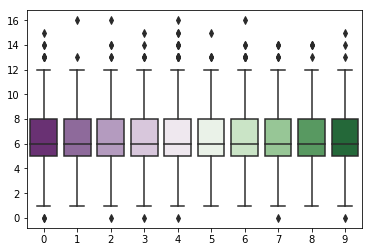

In [17]:
sns.boxplot(data=classes_stats_per_batches, palette="PRGn")

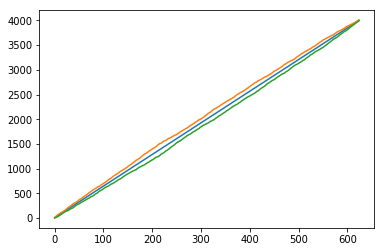

In [18]:
mean_n_classes = np.mean(np.cumsum(classes_stats_per_batches, axis=0), axis=1)
std_n_classes = np.std(np.cumsum(classes_stats_per_batches, axis=0), axis=1)

plt.plot(mean_n_classes)
plt.plot(mean_n_classes + 3.0 * std_n_classes)
plt.plot(mean_n_classes - 3.0 * std_n_classes)

## Setup model

Let's load a small neural network "SqueezeNet" that has only ~700K parameters, showing performances similar to AlexNet:
- Top-1 ImageNet Accuracy: 57.5% vs 57.2% (AlexNet)
- Top-5 ImageNet Accuracy: 80.3% vs 80.3% (AlexNet)

References:
- [paper](https://arxiv.org/pdf/1602.07360.pdf)

In [19]:
from torchvision.models import SqueezeNet

from common.nn_utils import print_trainable_parameters

In [20]:
squeezenet = SqueezeNet(num_classes=10, version=1.1)
print(squeezenet)

SqueezeNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Fire (
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (4): Fire (
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1,

In [21]:
print_trainable_parameters(squeezenet)

('features.0.weight', torch.Size([64, 3, 3, 3]))
('features.0.bias', torch.Size([64]))
('features.3.squeeze.weight', torch.Size([16, 64, 1, 1]))
('features.3.squeeze.bias', torch.Size([16]))
('features.3.expand1x1.weight', torch.Size([64, 16, 1, 1]))
('features.3.expand1x1.bias', torch.Size([64]))
('features.3.expand3x3.weight', torch.Size([64, 16, 3, 3]))
('features.3.expand3x3.bias', torch.Size([64]))
('features.4.squeeze.weight', torch.Size([16, 128, 1, 1]))
('features.4.squeeze.bias', torch.Size([16]))
('features.4.expand1x1.weight', torch.Size([64, 16, 1, 1]))
('features.4.expand1x1.bias', torch.Size([64]))
('features.4.expand3x3.weight', torch.Size([64, 16, 3, 3]))
('features.4.expand3x3.bias', torch.Size([64]))
('features.6.squeeze.weight', torch.Size([32, 128, 1, 1]))
('features.6.squeeze.bias', torch.Size([32]))
('features.6.expand1x1.weight', torch.Size([128, 32, 1, 1]))
('features.6.expand1x1.bias', torch.Size([128]))
('features.6.expand3x3.weight', torch.Size([128, 32, 3, 3

Let's put the model on GPU

In [22]:
squeezenet = squeezenet.cuda()

As we work with resized CIFAR10 images of size 42 x 42, we replace first layers that drastically reduce feature map size and adapt the last average pooling layer in order to avoid zero size feature maps. 

Let's see feature map sizes coming from `squeezenet.features`:
- from the first layers before the first 'fire' module: 
    - 0: Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    - 1: ReLU (inplace)
    - 2: MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
- the last layer before classification part:
    - 12: Fire

In [23]:
from torch.nn import AvgPool2d, Sequential, MaxPool2d, Conv2d

In [24]:
squeezenet.features[0], squeezenet.features[2] 

(Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2)),
 MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1)))

In [25]:
from torch.autograd import Variable

test_random_x = Variable(torch.randn(1, 3, 48, 48).pin_memory()).cuda(async=True)

squeezenet.eval()
test_output_y0 = squeezenet.features[0](test_random_x)
test_output_y1 = Sequential(squeezenet.features[0], squeezenet.features[1], squeezenet.features[2])(test_random_x)
test_output_y0.size(), test_output_y1.size()

(torch.Size([1, 64, 23, 23]), torch.Size([1, 64, 11, 11]))

Let's replace first layers : 
- `Conv2d (3, 64, kernel_size=(3, 3), stride=(2, 2))` by `Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1)`
- remove `MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1)))`

In [26]:
layers = [l for i, l in enumerate(squeezenet.features) if i != 2]
layers[0] = Conv2d(3, 64, kernel_size=(3, 3), padding=1)

squeezenet.features = Sequential(*layers)

In [27]:
print(squeezenet)

SqueezeNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Fire (
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (3): Fire (
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (4): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (5): Fire (
      (squeeze): Conv2d(128,

In [28]:
squeezenet = squeezenet.cuda()

In [29]:
from torch.autograd import Variable

test_random_x = Variable(torch.randn(1, 3, 42, 42).pin_memory()).cuda(async=True)

squeezenet.eval()
test_output_y = squeezenet.features(test_random_x)
test_output_y.size()

torch.Size([1, 512, 10, 10])

In [30]:
from torch.nn import AvgPool2d, Sequential

layers = [l for l in squeezenet.classifier]
layers[-1] = AvgPool2d(10)

squeezenet.classifier = Sequential(*layers)

In [31]:
print(squeezenet)

SqueezeNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Fire (
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (3): Fire (
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (4): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (5): Fire (
      (squeeze): Conv2d(128,

As we can see from previous prints, the last layer of the model is average pooling and the output of the forward pass is logits and not yet probabilities of classes:

In [32]:
from torch.autograd import Variable

test_random_x = Variable(torch.randn(1, 3, 48, 48).pin_memory()).cuda(async=True)

squeezenet.eval()
test_output_y = squeezenet(test_random_x)
test_output_y

Variable containing:
 0.0262  0.0050  0.0538  0.0001  0.0054  0.0026  0.0000  0.1106  0.0109  0.1962
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

## Setup loss function and optimizer

Let's choose classical cross-entropy loss function for this multiclass classification task and Adam as an optimizer.

In [33]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

In [34]:
# define loss function (criterion) and optimizer
criterion = CrossEntropyLoss().cuda()
optimizer = Adam(squeezenet.parameters())

Note that CrossEntropyLoss:

> This criterion combines `LogSoftMax` and `NLLLoss` in one single class.
> It is useful when training a classification problem with `n` classes.

> The `input` is expected to contain scores for each class.
> `input` has to be a 2D `Tensor` of size `batch x n`.

> This criterion expects a class index (0 to nClasses-1) as the
> `target` for each value of a 1D tensor of size `n`

>    The loss can be described as:
$$
        loss(x, class) = -log(exp(x[class]) / (\sum_j exp(x[j])))
                       = -x[class] + log(\sum_j exp(x[j]))
$$

Let's check loss function computation:

In [35]:
squeezenet.eval()

for i, (batch_x, batch_y) in enumerate(cuda_train_batches_ds):
    
    batch_x = Variable(batch_x, requires_grad=True)
    batch_y = Variable(batch_y)
    batch_y_pred = squeezenet(batch_x)
    loss = criterion(batch_y_pred, batch_y)
    print("Loss : ", loss.data)
    break

('Loss : ', 
 2.3079
[torch.cuda.FloatTensor of size 1 (GPU 0)]
)


## Setup training pipeline

Typical pipeline: 
- loops over training dataset during `n_epochs`
    - computes values of the loss function, accuracy, other metrics on train batches
- runs validation phase on validation dataset when training epoch ends
    - computes values of the loss function, accuracy, other metrics on whole validation dataset
- save on the disk the best model defined by a metric
- performs learning rate scheduling on each training epoch


Next, there are two ways:
- copy/modify code from examples: i.e. [link](https://github.com/pytorch/examples/blob/master/imagenet/main.py)
- use [torchsample](https://github.com/ncullen93/torchsample) or [tnt](https://github.com/pytorch/tnt) ...

Here we choose the first way and explicitly code a training pipeline based on various available examples.
Let's first define methods called in the training loop:

In [36]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [37]:
def train_one_epoch(model, cuda_batches, criterion, optimizer, epoch, n_epochs):    
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    # switch to train mode
    model.train()

    pbar = tqdm(total=len(cuda_batches))
    for i, (batch_x, batch_y) in enumerate(cuda_batches):

        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)

        # compute output
        batch_y_pred = model(batch_x)
        loss = criterion(batch_y_pred, batch_y)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(batch_y_pred.data, batch_y.data, topk=(1, 5))
        losses.update(loss.data[0], batch_x.size(0))
        top1.update(prec1[0], batch_x.size(0))
        top5.update(prec5[0], batch_x.size(0))

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        prefix_str = "Epoch: {}/{}".format(epoch + 1, n_epochs)        
        pbar.set_description_str(prefix_str, refresh=False)
        
        post_fix_str = 'Loss {loss.avg:.4f} | ' + \
                        'Prec@1 {top1.avg:.3f} | ' + \
                        'Prec@5 {top5.avg:.3f}'
                        
        post_fix_str = post_fix_str.format(loss=losses, top1=top1, top5=top5)
        
        pbar.set_postfix_str(post_fix_str, refresh=True)
        pbar.update(1)
    pbar.close()

In [38]:
def validate(model, cuda_batches, criterion):
    
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    pbar = tqdm(total=len(cuda_batches))
    for i, (batch_x, batch_y) in enumerate(cuda_batches):

        batch_x = Variable(batch_x, volatile=True)  # volatile means that the Variable should be used in inference mode, i.e. don’t save the history.
        batch_y = Variable(batch_y, volatile=True)   # see http://pytorch.org/docs/master/autograd.html#variable

        # compute output
        batch_y_pred = model(batch_x)
        loss = criterion(batch_y_pred, batch_y)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(batch_y_pred.data, batch_y.data, topk=(1, 5))
        losses.update(loss.data[0], batch_x.size(0))
        top1.update(prec1[0], batch_x.size(0))
        top5.update(prec5[0], batch_x.size(0))

        pbar.set_description_str("Test", refresh=False)
        post_fix_str = 'Loss {loss.avg:.4f} | ' + \
                        'Prec@1 {top1.avg:.3f} | ' + \
                        'Prec@5 {top5.avg:.3f}'
        post_fix_str = post_fix_str.format(loss=losses, top1=top1, top5=top5)
        
        pbar.set_postfix_str(post_fix_str, refresh=True)
        pbar.update(1)
    pbar.close()                        
    return top1.avg
    

In [39]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau


scheduler = ExponentialLR(optimizer, gamma=0.95)

In [40]:
import shutil
from glob import glob

def save_checkpoint(logs_path, state, is_best):
    filename='checkpoint_{epoch}_val_prec1={val_prec1:.4f}.pth.tar'.format(
        epoch=state['epoch'],
        val_prec1=state['val_prec1']
    )
    torch.save(state, os.path.join(logs_path, filename))
    if is_best:        
        best_model_filenames = glob(os.path.join(logs_path, 'model_val_prec1*'))
        for fn in best_model_filenames:
            os.remove(fn)        
        best_model_filename='model_val_prec1={val_prec1:.4f}.pth.tar'.format(
            val_prec1=state['val_prec1']
        )
        shutil.copyfile(os.path.join(logs_path, filename), os.path.join(logs_path, best_model_filename))    

### Now we can start training

In [41]:
start_epoch = 0 
n_epochs = 10
model = squeezenet
init_lr = 0.0001

In [42]:
from torch.backends import cudnn
cudnn.benchmark

False

> What does torch.backends.cudnn.benchmark do? [url](https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/2)

In [43]:
cudnn.benchmark = True

In [44]:
optimizer = Adam(squeezenet.parameters(), lr=init_lr)

In [46]:
from datetime import datetime


best_prec1 = 0
now = datetime.now()

if not os.path.exists('logs'):
    os.makedirs('logs')
    
logs_path = os.path.join('logs', 'cifar10_squeezenet_%s' % now.strftime("%Y%m%d_%H%M"))
if not os.path.exists(logs_path):
    os.makedirs(logs_path)    


for epoch in range(start_epoch, n_epochs):
    
    scheduler.step()

    # train for one epoch
    train_one_epoch(model, cuda_train_batches_ds, criterion, optimizer, epoch, n_epochs)

    # evaluate on validation set
    prec1 = validate(model, cuda_val_batches_ds, criterion)

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint(logs_path, {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'val_prec1': prec1,
        'best_prec1': best_prec1,
        'optimizer' : optimizer.state_dict()}, is_best)

Test: 100%|██████████| 156/156 [00:03<00:00, 42.86it/s, Loss 1.3952 | Prec@1 49.519 | Prec@5 92.448]


### Inference

Let's upload the best saved model and run inference on the testing dataset

In [47]:
saved_model_filenames = glob(os.path.join(logs_path, "model_val_prec1=*"))
assert len(saved_model_filenames) > 0

In [48]:
saved_model_filename = saved_model_filenames[0]
saved_model_filename

'logs/cifar10_squeezenet_20171113_1830/model_val_prec1=50.8714.pth.tar'

In [49]:
pretrained_squeezenet_state_dict = torch.load(saved_model_filename)

In [50]:
squeezenet.load_state_dict(pretrained_squeezenet_state_dict['state_dict'])

In [51]:
# evaluate on validation set
prec1 = validate(squeezenet, cuda_test_batches_ds, criterion)
prec1

Test: 100%|██████████| 156/156 [00:02<00:00, 52.31it/s, Loss 1.3473 | Prec@1 51.482 | Prec@5 93.199]


51.482371794871796